In [144]:
############

# XGboost

###########

import warnings
warnings.filterwarnings('ignore')

In [145]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import xgboost as xgb
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')
sns.set(font_scale=2)
%matplotlib inline

In [146]:
data = pd.read_csv("S_n_I_A_N_P_An_Io_noaa2.txt",delimiter=' ',skipinitialspace=True, names = ['SAM', 'nino', 'ISMR', 'AMO', 'NAO', 'PDO', 'At-nino', 'IOD'],index_col = False,engine='python')
data

,SAM,nino,ISMR,AMO,NAO,PDO,At-nino,IOD
0,0.599257,0.167651,10.24380,0.484010,0.000837,1.084100,0.560382,-0.295856
1,0.663879,0.212788,44.16110,0.603261,-0.317969,-1.465790,1.189540,-0.032952
2,-0.428772,0.336627,4.76807,0.609364,0.423296,0.114019,0.783738,-0.644708
3,0.513283,0.575112,-63.58770,0.219494,0.352545,1.807430,0.560395,-0.295477
4,-0.260801,0.647786,12.57720,0.040233,-0.528239,-0.108867,0.727379,0.044719
...,...,...,...,...,...,...,...,...
865,1.147740,1.296340,23.70850,0.161498,-0.385948,0.108982,-0.079691,0.297551
866,1.579510,1.572200,-41.18450,0.174294,-0.945931,2.158290,-0.189664,0.441171
867,0.923487,2.007070,-56.14030,0.277507,0.413170,0.031796,-0.188361,0.534373
868,0.207229,2.259830,-43.77540,0.492069,-0.579453,-1.432400,0.008520,0.771095


<AxesSubplot:>

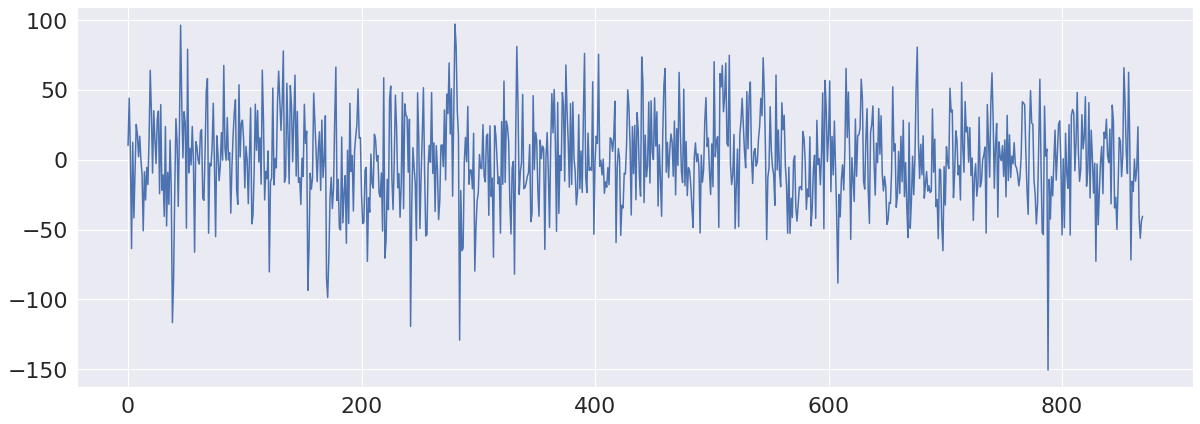

In [147]:
data['ISMR'].plot(kind='line', figsize=(20,7))

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SAM      870 non-null    float64
 1   nino     870 non-null    float64
 2   ISMR     870 non-null    float64
 3   AMO      870 non-null    float64
 4   NAO      870 non-null    float64
 5   PDO      870 non-null    float64
 6   At-nino  870 non-null    float64
 7   IOD      870 non-null    float64
dtypes: float64(8)
memory usage: 54.5 KB


In [149]:
features = [ 'nino', 'AMO', 'NAO', 'PDO', 'At-nino', 'IOD'] # skip SAM as it was told to omit in question
target = 'ISMR'

In [150]:
dX = data[features].iloc[:]
dy = data[target].iloc[:]

accs = 100
best_lag = -1

lag_vs_acc_table = {"root mean squared error" : [], "lag" : []}

In [151]:
def give_lagged_dataset(X,y,lag):
    lX = pd.DataFrame(features)
    ly = pd.DataFrame([target])
    iX = []
    iY = []
    rows = X.shape[0]
    for i in range(rows):
        rem = i%6
        if(lag>rem):
            continue
        else:
            iX += [i-lag]
            iY += [i]
    lX = X.loc[iX]
    ly = y.loc[iY]
    return lX,ly

In [152]:
def evaluate_model_for_a_lag_of(lag):
    X,y = give_lagged_dataset(dX,dy,lag)
    
    global accs
    global best_lag
    
    xgbmodel = xgb.XGBRegressor()
    
    xgbmodel.fit(X,y)
    ypred = xgbmodel.predict(X)
    score = mse(ypred, y)

    lag_vs_acc_table["root mean squared error"] += [np.sqrt(score)]
    lag_vs_acc_table["lag"] += [lag]
    
    print('------------------------------------------------------')
    print("Root mean squared error is " + str(score) + " at a lag of "+str(lag) + " months")
    print('------------------------------------------------------')
    
    if(score < accs):
        best_lag = lag
        accs = score
    
    
    
    dat = {'True Values': y, "Predicted Values": ypred}
    df_res = pd.DataFrame()
    df_res = df_res.append(pd.DataFrame(data=dat),ignore_index=True)
    display(df_res)
    plt.figure(figsize=(16,9))
    plt.scatter(y=y,x=range(len(y)),label = 'True Values')
    plt.scatter(y=ypred,x=range(len(ypred)),label = "Predicted Values")
    plt.legend()
    
    plt.title("Lag of "+str(lag)+" months")
    plt.show()

------------------------------------------------------
Root mean squared error is 8.245697997419972 at a lag of 0 months
------------------------------------------------------


,True Values,Predicted Values
0,10.24380,3.316878
1,44.16110,44.264484
2,4.76807,2.391349
3,-63.58770,-59.615692
4,12.57720,11.700466
...,...,...
865,23.70850,21.275038
866,-41.18450,-41.116432
867,-56.14030,-55.340015
868,-43.77540,-44.009186


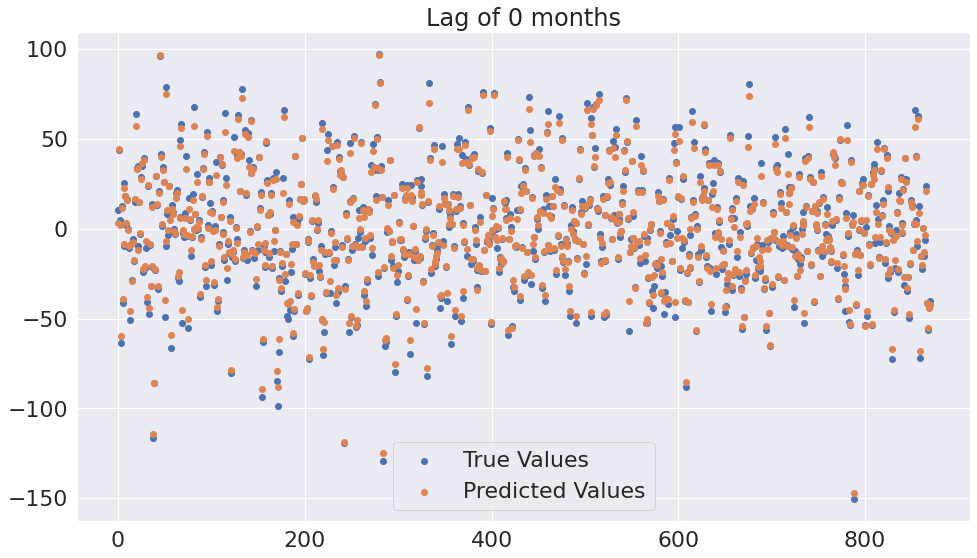

In [153]:
# ---------------
# lag of 0 months
# ---------------

evaluate_model_for_a_lag_of(0)


------------------------------------------------------
Root mean squared error is 4.226913214144224 at a lag of 1 months
------------------------------------------------------


,True Values,Predicted Values
0,44.16110,41.903690
1,4.76807,4.299681
2,-63.58770,-62.391327
3,12.57720,11.832775
4,-41.57720,-37.819962
...,...,...
720,23.70850,24.766338
721,-41.18450,-39.384018
722,-56.14030,-55.377113
723,-43.77540,-42.099026


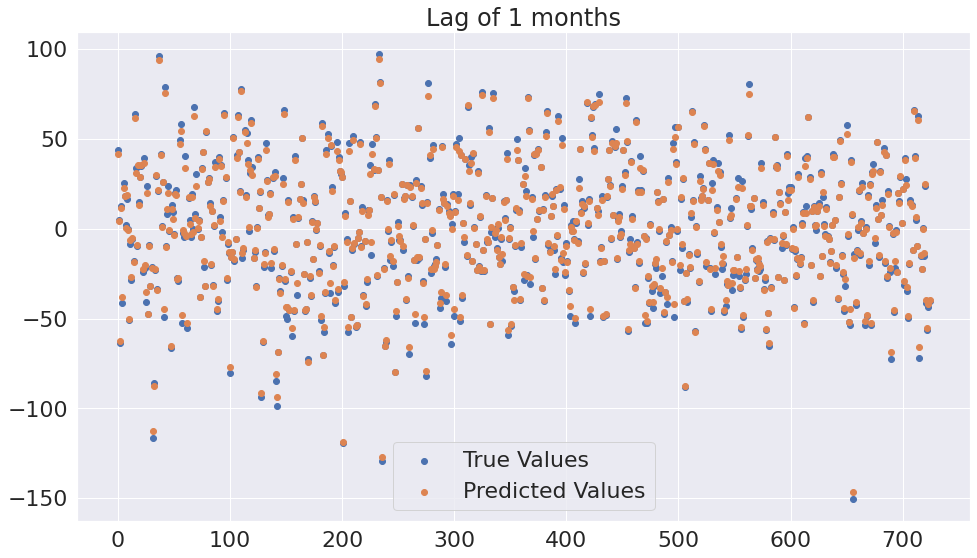

In [154]:
# ---------------
# lag of 1 months
# ---------------

evaluate_model_for_a_lag_of(1)

------------------------------------------------------
Root mean squared error is 2.6356032591460363 at a lag of 2 months
------------------------------------------------------


,True Values,Predicted Values
0,4.76807,5.360354
1,-63.58770,-62.092552
2,12.57720,12.166120
3,-41.57720,-40.964188
4,18.27740,17.950943
...,...,...
575,-15.23920,-13.349544
576,-41.18450,-41.448849
577,-56.14030,-54.961395
578,-43.77540,-43.826832


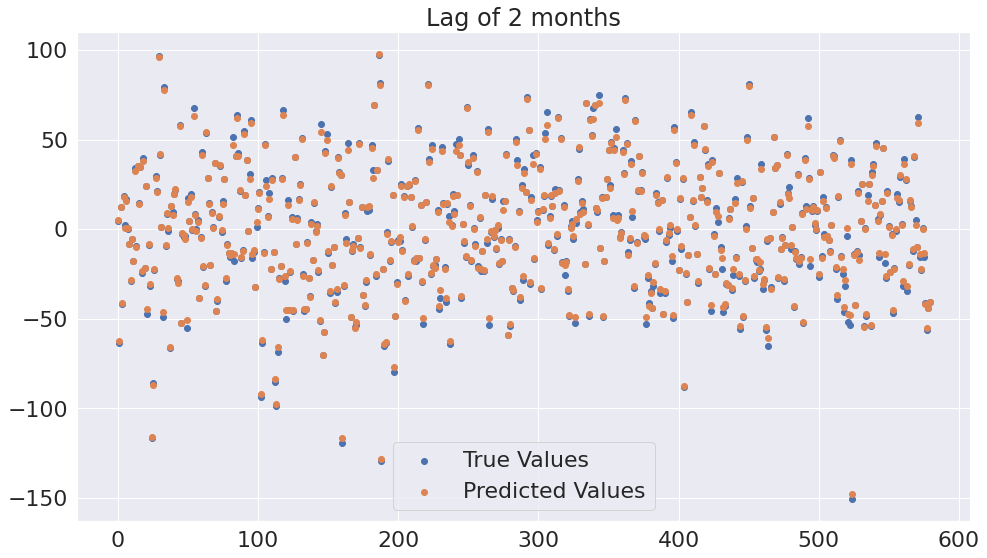

In [155]:
# ---------------
# lag of 2 months
# ---------------

evaluate_model_for_a_lag_of(2)

------------------------------------------------------
Root mean squared error is 0.30412075379967646 at a lag of 3 months
------------------------------------------------------


,True Values,Predicted Values
0,-63.587700,-63.379833
1,12.577200,12.117350
2,-41.577200,-40.916767
3,2.221670,2.219107
4,16.886600,17.747038
...,...,...
430,0.515238,-0.867526
431,-15.239200,-15.244044
432,-56.140300,-56.082703
433,-43.775400,-43.899738


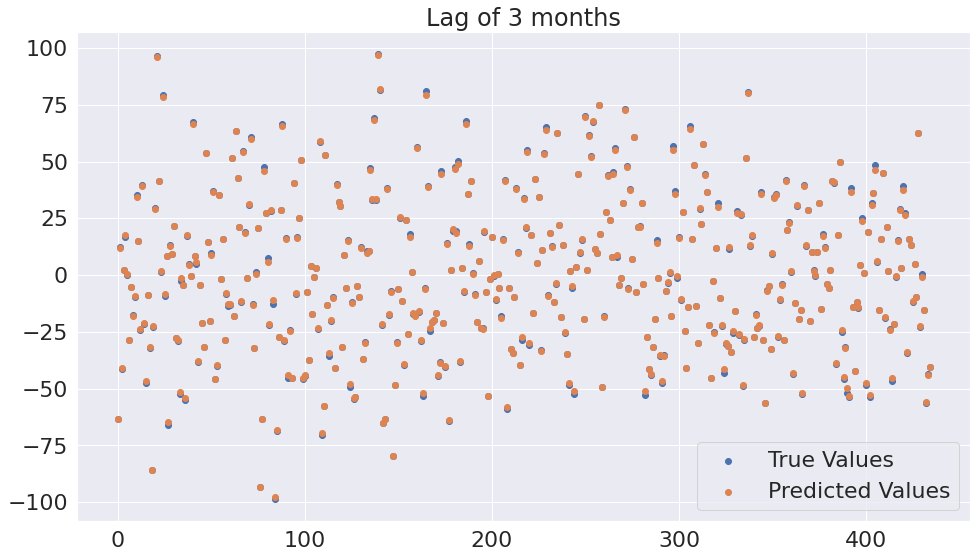

In [156]:
# ---------------
# lag of 3 months
# ---------------

evaluate_model_for_a_lag_of(3)

------------------------------------------------------
Root mean squared error is 0.008583497989903866 at a lag of 4 months
------------------------------------------------------


,True Values,Predicted Values
0,12.577200,12.538363
1,-41.577200,-41.495049
2,16.886600,16.920177
3,0.132196,0.111599
4,-5.404050,-5.364642
...,...,...
285,62.651500,62.652855
286,0.515238,0.520443
287,-15.239200,-15.271508
288,-43.775400,-43.786629


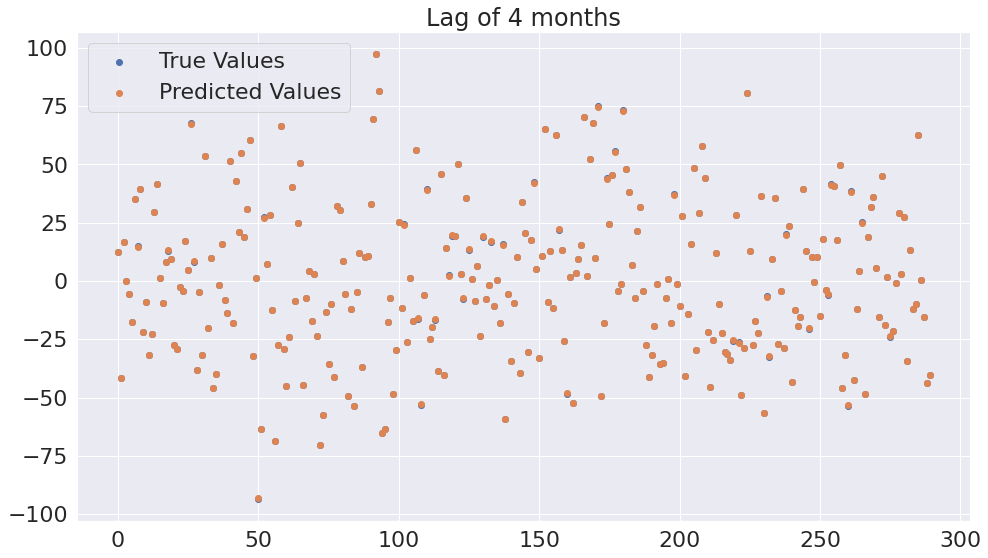

In [157]:
# ---------------
# lag of 4 months
# ---------------

evaluate_model_for_a_lag_of(4)

------------------------------------------------------
Root mean squared error is 4.530276679918237e-06 at a lag of 5 months
------------------------------------------------------


,True Values,Predicted Values
0,-41.577200,-41.577824
1,0.132196,0.129992
2,-17.658400,-17.658390
3,14.850900,14.850644
4,-21.739700,-21.738365
...,...,...
140,-34.467200,-34.466827
141,-12.057900,-12.057352
142,62.651500,62.652603
143,-15.239200,-15.237147


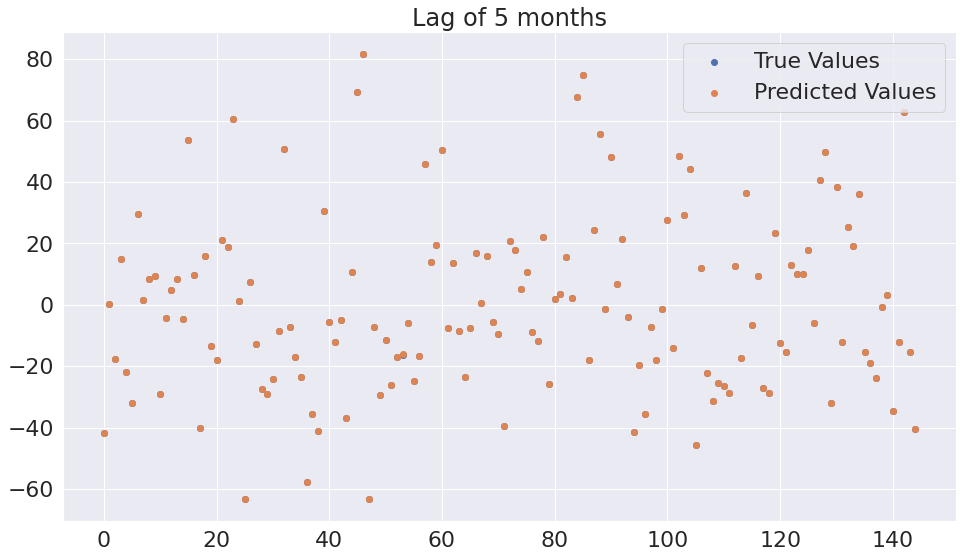

In [158]:
# ---------------
# lag of 5 months
# ---------------

evaluate_model_for_a_lag_of(5)

In [159]:
display(pd.DataFrame(lag_vs_acc_table))
print("=======================================")
print("So the best lag value is " + str(best_lag) + " months")
print("=======================================")

,root mean squared error,lag
0,2.871532,0
1,2.055946,1
2,1.623454,2
3,0.551471,3
4,0.092647,4
5,0.002128,5


So the best lag value is 5 months
